In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(['0006'])
cohort.load_images()
cohort.preprocess()
dataset = cohort.to_dataset()
dataset.save_xarrays('../data/NAFLD3')

In [36]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v4', '0006', anat=True)
example.metadata

Loading ../data/NAFLD/v4/0006/wave.nc
Loading ../data/NAFLD/v4/0006/mre.nc
Loading ../data/NAFLD/v4/0006/mre_mask.nc
Loading ../data/NAFLD/v4/0006/anat.nc
Loading ../data/NAFLD/v4/0006/anat_mask.nc


size   spacing    origin     limit    center    extent
variable dimension                                                        
wave     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre      x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre_mask x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
anat     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000

In [37]:
example.anat

<xarray.DataArray 't1_pre_in' (x: 256, y: 256, z: 4, component: 5)>
[1310720 values with dtype=float32]
Coordinates:
  * x          (x) float64 -0.4138 -0.411 -0.4082 ... 0.2978 0.3006 0.3034
  * y          (y) float64 -0.3917 -0.3889 -0.3861 ... 0.3199 0.3227 0.3255
  * z          (z) float64 -0.002113 0.01989 0.04189 0.06389
  * component  (component) object 't1_pre_in' 't1_pre_out' ... 't1_pre_fat' 't2'
    region     (x, y, z) float32 ...

In [38]:
example.describe()

dtype     count         mean          std        min  \
variable component                                                              
wave     scalar        float64  262144.0     0.000139     0.023588  -0.099609   
mre      scalar          int16  262144.0  1505.871937  1335.735833   0.000000   
mre_mask scalar        float32  262144.0     0.171467     0.376916   0.000000   
anat     t1_pre_in     float32  262144.0   284.291534   348.797943 -21.549210   
         t1_pre_out    float32  262144.0   233.678009   306.809906 -13.558849   
         t1_pre_water  float32  262144.0   148.629425   197.089142 -18.226978   
         t1_pre_fat    float32  262144.0   167.445847   374.024628 -56.603508   
         t2            float32  262144.0    86.427055   118.790413 -29.458336   

                             25%          50%          75%           max  
variable component                                                        
wave     scalar        -0.004492     0.000000     0.004736      0.099609  
mre      scalar         0.000000  1340.000000  2212.000000  14078.000000  
mre_mask scalar         0.000000     0.000000     0.000000      1.000000  
anat     t1_pre_in     29.193789   180.042618   429.296043   2863.383545  
         t1_pre_out    29.089085   117.483658   328.673340   2556.969727  
         t1_pre_water  15.186593    39.857546   265.889618   2288.550781  
         t1_pre_fat    15.474017    29.796385    87.772732   3595.086182  
         t2             0.521056    31.247707   129.638935    884.129272

In [39]:
mre_pinn.baseline.eval_direct_baseline(example, frequency=40)
mre_pinn.baseline.eval_fem_baseline(example, frequency=40, hetero=True)

Evaluating direct baseline
Evaluating FEM baseline
100%|██████████| 4/4 [22:44<00:00, 341.25s/it]


In [40]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=40, detach=True)

In [41]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=5,
    n_hidden=128,
    polar_input=True
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (hidden3): Linear(in_features=390, out_features=128, bias=True)
    (output): Linear(in_features=518, out_features=1, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (hidden3): Linear(in_features=390, out_features=128, bias=True)
    (output): Linear(in_features=518, out_features=6, bias=True)
  )
)

In [42]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1, 1e-16],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-18,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000235 s



In [43]:
example.anat

<xarray.DataArray 't1_pre_in' (x: 256, y: 256, z: 4, component: 5)>
[1310720 values with dtype=float32]
Coordinates:
  * x          (x) float64 -0.4138 -0.411 -0.4082 ... 0.2978 0.3006 0.3034
  * y          (y) float64 -0.3917 -0.3889 -0.3861 ... 0.3199 0.3227 0.3255
  * z          (z) float64 -0.002113 0.01989 0.04189 0.06389
  * component  (component) object 't1_pre_in' 't1_pre_out' ... 't1_pre_fat' 't2'
    region     (x, y, z) float32 ...

In [44]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0298s (8.13%)
Model time/iter: 0.2421s (66.11%)
Loss time/iter:  0.0943s (25.76%)
Total time/iter: 0.3662s
Total time: 36.6229s
1k iters time: 6.10m
10k iters time: 61.04m
100k iters time: 10.17h


In [45]:
for t in model.data.get_raw_tensors(device='cpu', patch_size=1):
    print(t.dtype, t.shape)

torch.float32 torch.Size([262144, 3])
torch.float64 torch.Size([262144, 1])
torch.int16 torch.Size([262144, 1])
torch.bool torch.Size([262144])
torch.float32 torch.Size([262144, 5])


<IPython.core.display.Javascript object>


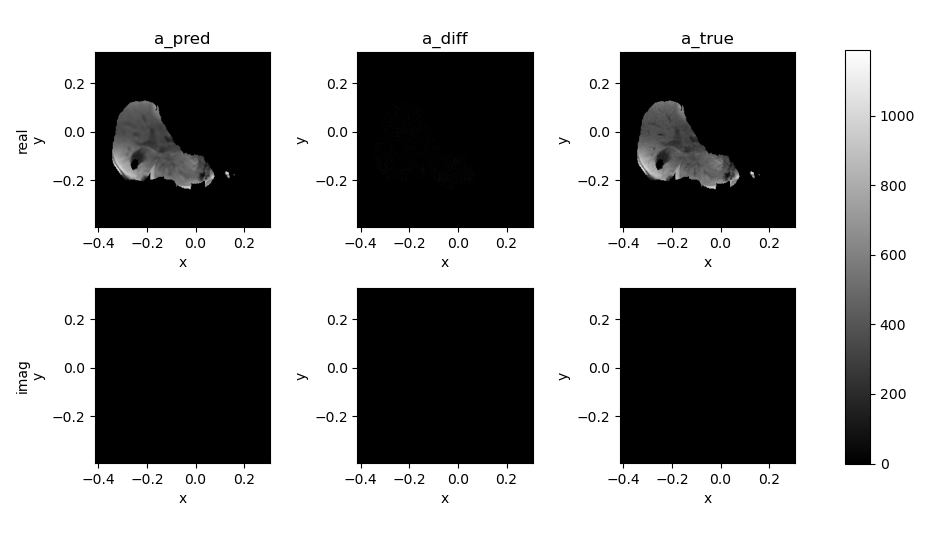

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


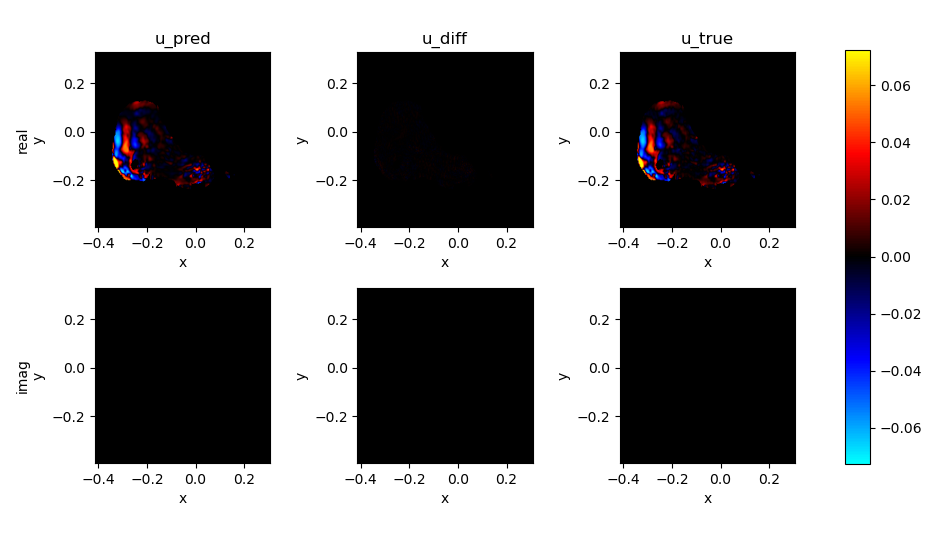

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


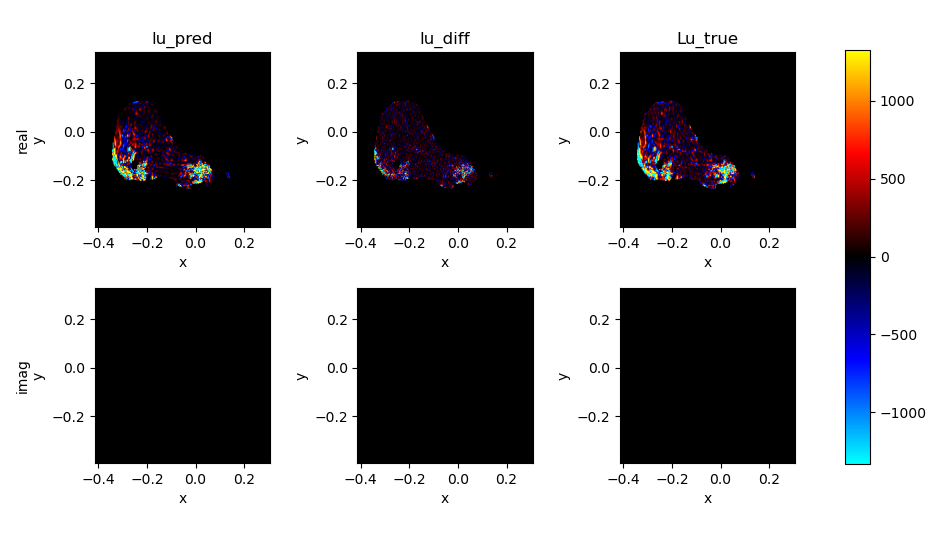

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


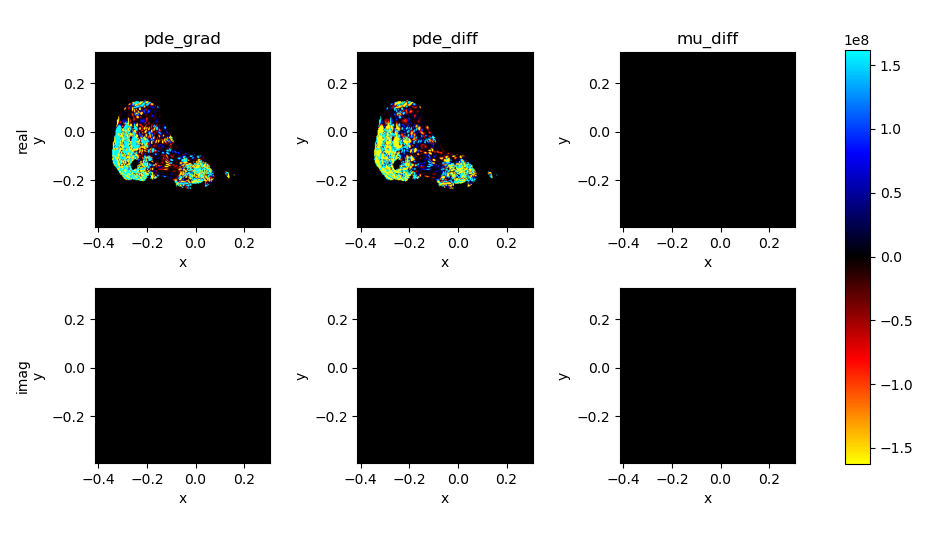

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


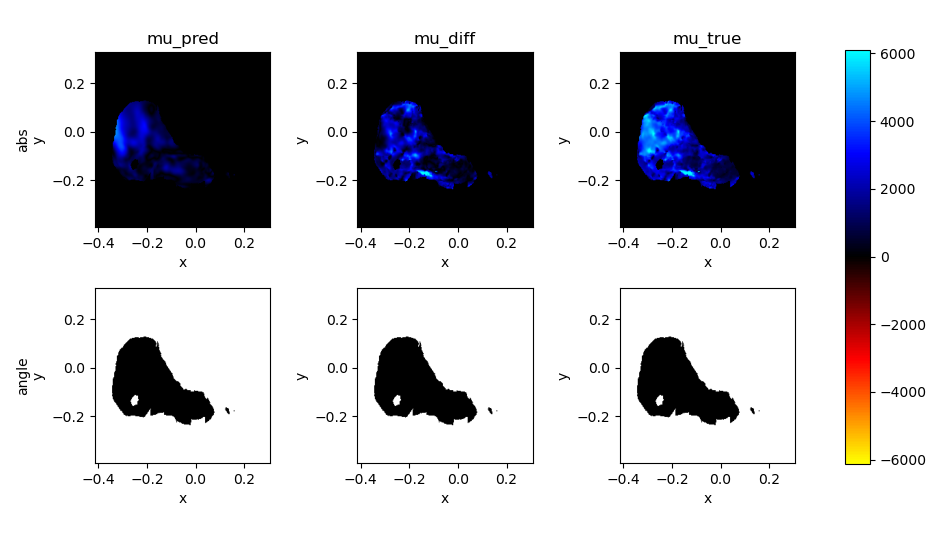

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


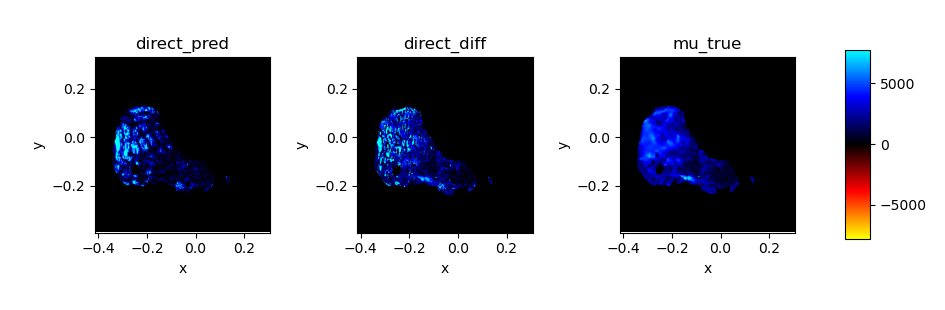

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


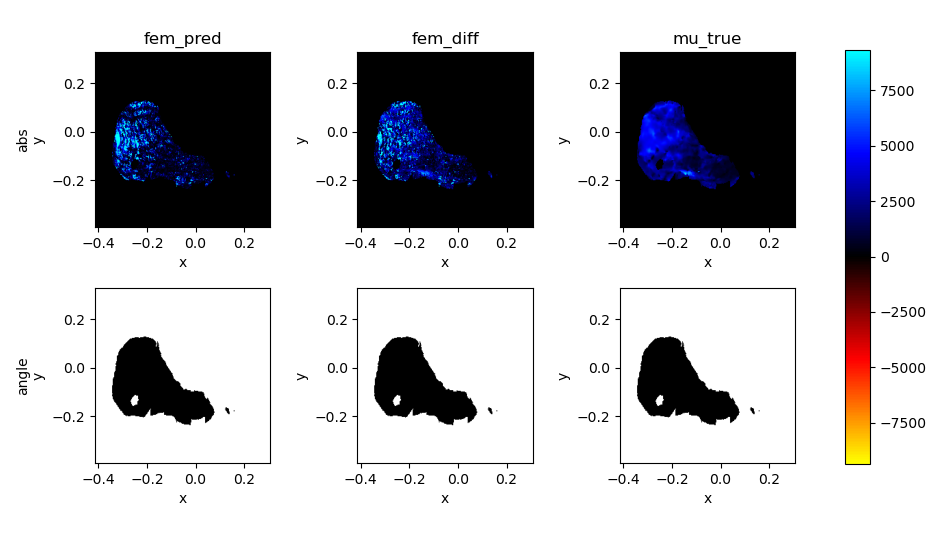

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [46]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.70e-03, 0.00e+00, 3.53e+05, 0.00e+00]    [1.78e-03, 0.00e+00, 3.55e+05, 0.00e+00]    []  


<IPython.core.display.Javascript object>


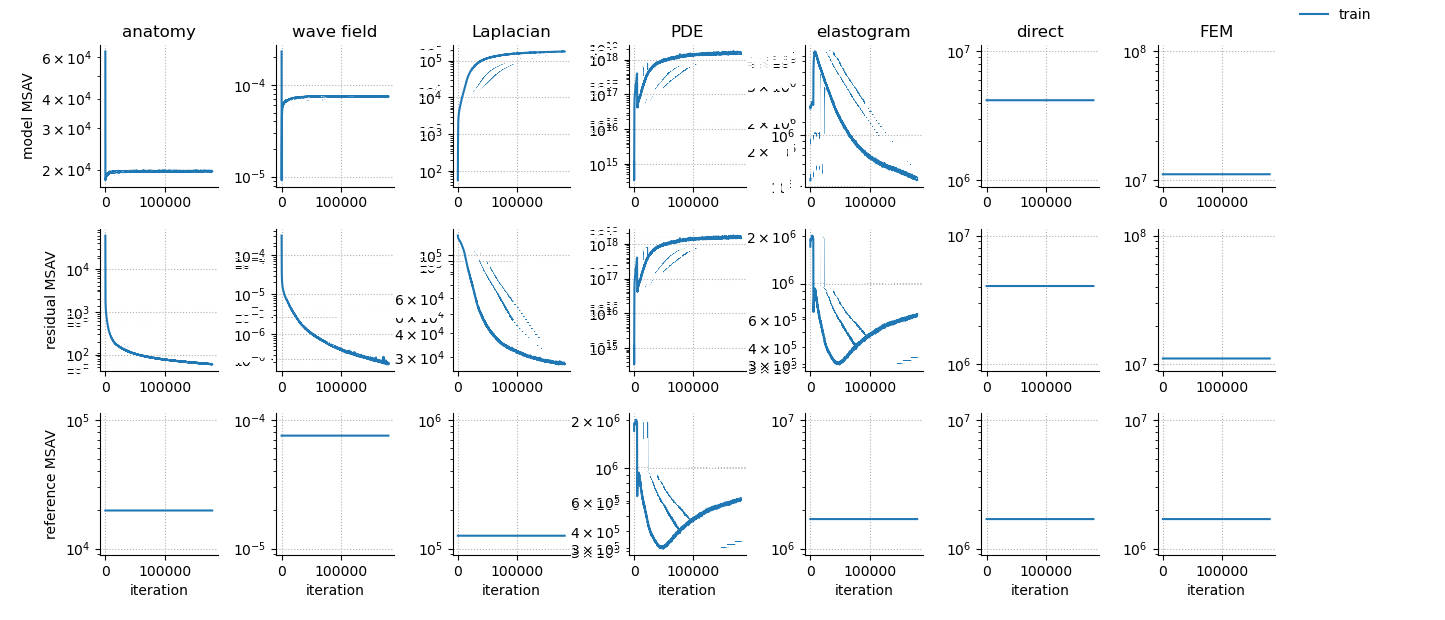

<IPython.core.display.Javascript object>


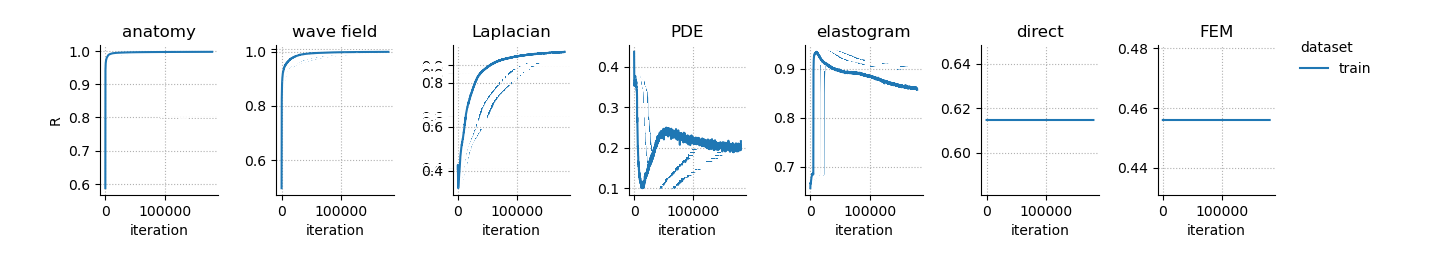

<IPython.core.display.Javascript object>


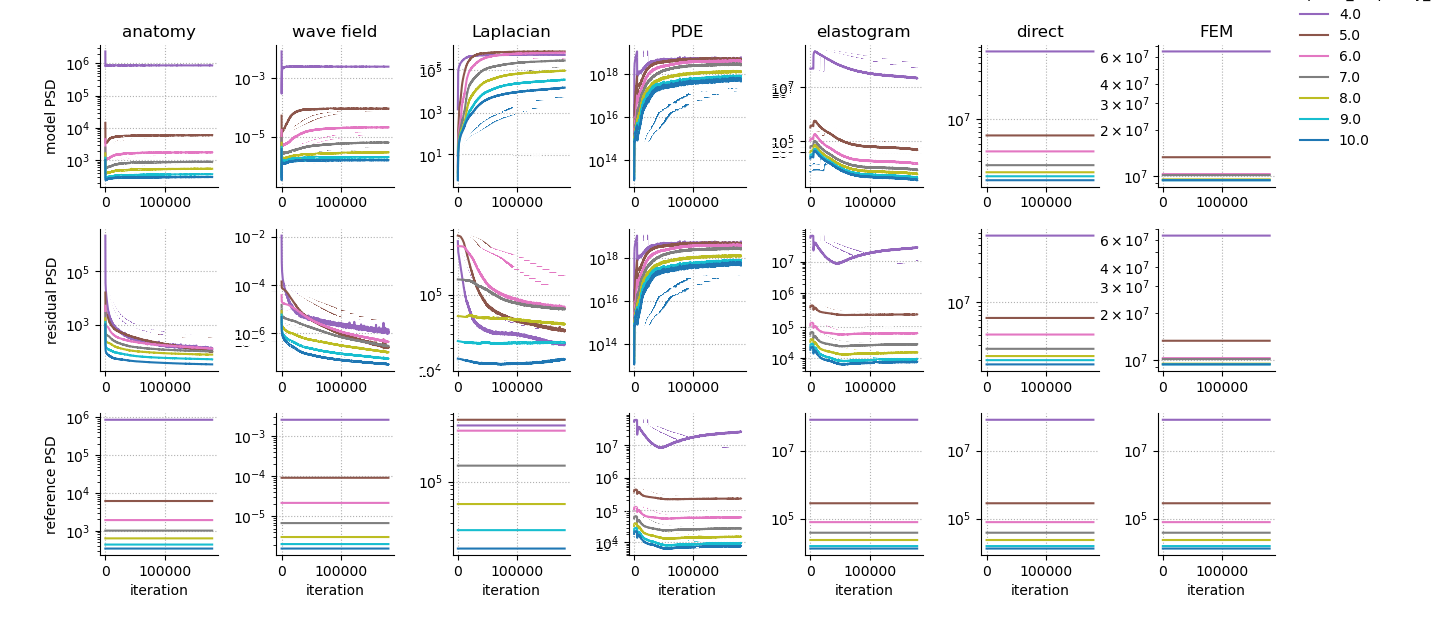

<IPython.core.display.Javascript object>


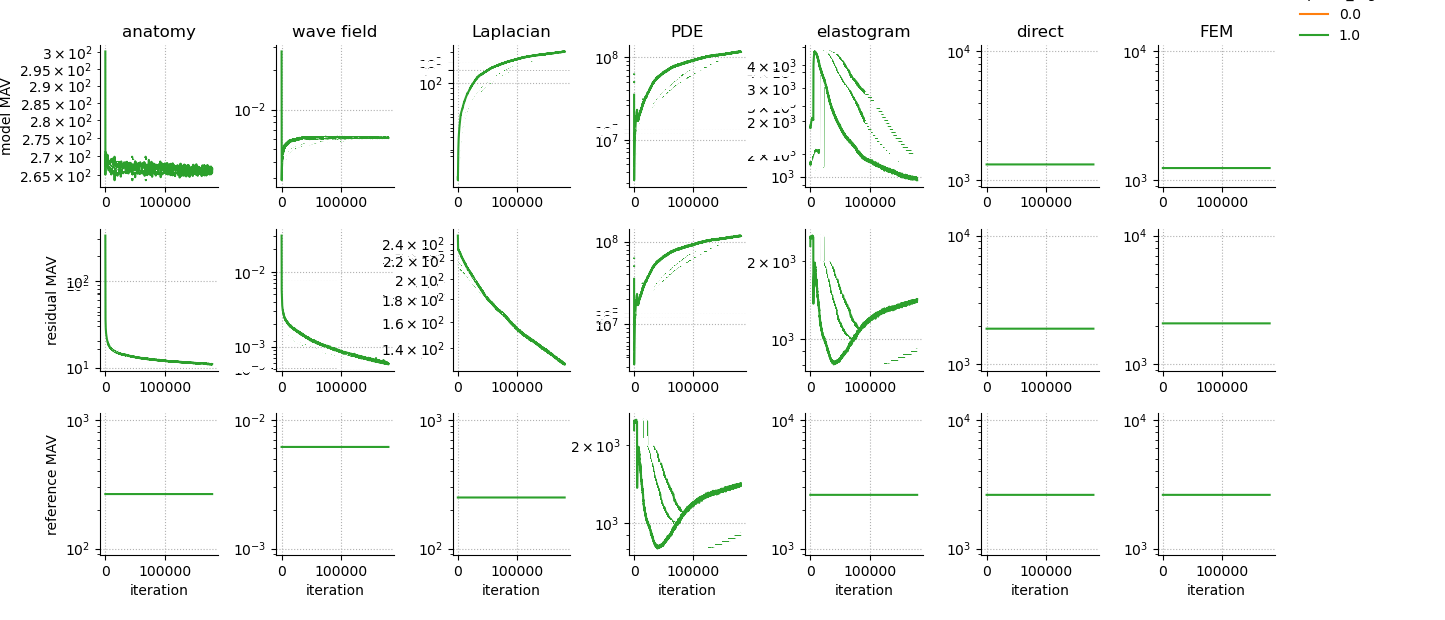

Time spent testing: 53.6245 (39.55%)
Time spent testing: 47.1480 (52.32%)
Time spent testing: 43.8684 (59.37%)
Time spent testing: 41.7490 (63.77%)
Time spent testing: 44.5599 (66.60%)
Time spent testing: 45.9177 (68.91%)
Time spent testing: 41.2708 (70.75%)
Time spent testing: 42.5185 (71.76%)
Time spent testing: 42.2618 (72.93%)
Time spent testing: 44.9631 (74.28%)
1000      [1.18e-04, 0.00e+00, 6.46e+03, 0.00e+00]    [1.16e-04, 0.00e+00, 6.65e+03, 0.00e+00]    []  
Time spent testing: 46.5169 (75.09%)
Time spent testing: 44.3662 (75.61%)
Time spent testing: 57.1961 (76.85%)
Time spent testing: 45.0137 (77.19%)
Time spent testing: 46.7355 (77.65%)
Time spent testing: 47.0790 (78.05%)
Time spent testing: 47.2059 (78.42%)
Time spent testing: 43.1742 (78.95%)
Time spent testing: 45.2156 (79.22%)
Time spent testing: 47.7208 (79.51%)
2000      [8.13e-05, 0.00e+00, 4.70e+03, 0.00e+00]    [9.27e-05, 0.00e+00, 4.84e+03, 0.00e+00]    []  
Time spent testing: 40.8900 (79.66%)
Time spent testin

Time spent testing: 36.9034 (87.76%)
Time spent testing: 41.4296 (87.77%)
Time spent testing: 39.8109 (87.77%)
Time spent testing: 40.1744 (87.80%)
Time spent testing: 37.0135 (87.78%)
18000     [2.69e-05, 0.00e+00, 9.54e+02, 6.14e-05]    [2.76e-05, 0.00e+00, 1.08e+03, 5.71e-05]    []  
Time spent testing: 37.8393 (87.80%)
Time spent testing: 39.4118 (87.81%)
Time spent testing: 38.9557 (87.83%)
Time spent testing: 40.2243 (87.85%)
Time spent testing: 38.7487 (87.84%)
Time spent testing: 37.5373 (87.84%)
Time spent testing: 37.6633 (87.87%)
Time spent testing: 38.2975 (87.86%)
Time spent testing: 39.3430 (87.86%)
Time spent testing: 37.6027 (87.88%)
19000     [2.28e-05, 0.00e+00, 1.01e+03, 5.75e-05]    [2.55e-05, 0.00e+00, 1.09e+03, 5.94e-05]    []  
Time spent testing: 39.1746 (87.87%)
Time spent testing: 36.5235 (87.86%)
Time spent testing: 41.6770 (87.88%)
Time spent testing: 36.1708 (87.88%)
Time spent testing: 39.2850 (87.88%)
Time spent testing: 39.0292 (87.90%)
Time spent testin

35000     [8.46e-06, 0.00e+00, 6.81e+02, 8.37e-05]    [1.10e-05, 0.00e+00, 8.32e+02, 7.70e-05]    []  
Time spent testing: 43.3137 (87.63%)
Time spent testing: 43.4502 (87.62%)
Time spent testing: 44.1440 (87.62%)
Time spent testing: 43.0907 (87.61%)
Time spent testing: 40.7916 (87.61%)
Time spent testing: 44.6199 (87.59%)
Time spent testing: 41.1759 (87.60%)
Time spent testing: 46.9400 (87.59%)
Time spent testing: 41.5348 (87.58%)
Time spent testing: 41.5970 (87.58%)
36000     [8.42e-06, 0.00e+00, 6.34e+02, 7.64e-05]    [1.06e-05, 0.00e+00, 8.08e+02, 7.67e-05]    []  
Time spent testing: 42.4432 (87.59%)
Time spent testing: 36.5962 (87.58%)
Time spent testing: 39.3716 (87.59%)
Time spent testing: 36.2522 (87.60%)
Time spent testing: 38.8078 (87.61%)
Time spent testing: 40.7957 (87.62%)
Time spent testing: 36.5913 (87.63%)
Time spent testing: 37.8376 (87.64%)
Time spent testing: 38.4844 (87.65%)
Time spent testing: 35.9202 (87.66%)
37000     [8.95e-06, 0.00e+00, 6.97e+02, 8.39e-05]    

Time spent testing: 48.4616 (88.26%)
Time spent testing: 47.8051 (88.25%)
Time spent testing: 53.8071 (88.26%)
Time spent testing: 49.7456 (88.25%)
Time spent testing: 47.5247 (88.25%)
Time spent testing: 50.9274 (88.24%)
Time spent testing: 48.1533 (88.25%)
57000     [5.31e-06, 0.00e+00, 5.72e+02, 8.59e-05]    [6.22e-06, 0.00e+00, 6.42e+02, 8.88e-05]    []  
Time spent testing: 46.5289 (88.24%)
Time spent testing: 51.8285 (88.25%)
Time spent testing: 48.4707 (88.23%)
Time spent testing: 50.3171 (88.23%)
Time spent testing: 47.7447 (88.22%)
Time spent testing: 49.3553 (88.22%)
Time spent testing: 50.8778 (88.22%)
Time spent testing: 51.9473 (88.22%)
Time spent testing: 50.5456 (88.21%)
Time spent testing: 50.0887 (88.21%)
58000     [4.32e-06, 0.00e+00, 5.96e+02, 9.28e-05]    [6.07e-06, 0.00e+00, 6.39e+02, 8.84e-05]    []  
Time spent testing: 47.8015 (88.20%)
Time spent testing: 49.7373 (88.21%)
Time spent testing: 50.1632 (88.20%)
Time spent testing: 52.7624 (88.21%)
Time spent testin

Time spent testing: 44.0116 (88.63%)
Time spent testing: 43.8283 (88.62%)
Time spent testing: 47.4529 (88.63%)
Time spent testing: 45.3307 (88.63%)
Time spent testing: 46.1911 (88.63%)
Time spent testing: 46.3312 (88.63%)
Time spent testing: 51.6193 (88.62%)
Time spent testing: 49.6316 (88.63%)
81000     [2.90e-06, 0.00e+00, 4.82e+02, 8.69e-05]    [3.63e-06, 0.00e+00, 5.57e+02, 9.13e-05]    []  
Time spent testing: 53.7041 (88.62%)
Time spent testing: 47.2023 (88.62%)
Time spent testing: 47.5516 (88.62%)
Time spent testing: 51.9722 (88.62%)
Time spent testing: 49.5005 (88.61%)
Time spent testing: 49.5147 (88.61%)
Time spent testing: 47.4887 (88.61%)
Time spent testing: 46.5654 (88.61%)
Time spent testing: 53.9753 (88.61%)
Time spent testing: 52.2095 (88.61%)
82000     [2.81e-06, 0.00e+00, 4.44e+02, 8.62e-05]    [3.67e-06, 0.00e+00, 5.30e+02, 8.96e-05]    []  
Time spent testing: 49.1268 (88.61%)
Time spent testing: 50.5569 (88.61%)
Time spent testing: 52.2177 (88.60%)
Time spent testin

Time spent testing: 39.3739 (88.92%)
Time spent testing: 39.5444 (88.93%)
Time spent testing: 41.1101 (88.93%)
98000     [2.07e-06, 0.00e+00, 4.06e+02, 9.91e-05]    [2.66e-06, 0.00e+00, 4.85e+02, 9.09e-05]    []  
Time spent testing: 41.0718 (88.93%)
Time spent testing: 40.3362 (88.94%)
Time spent testing: 41.0251 (88.94%)
Time spent testing: 41.0546 (88.95%)
Time spent testing: 40.9857 (88.95%)
Time spent testing: 40.5797 (88.96%)
Time spent testing: 40.5246 (88.96%)
Time spent testing: 44.0321 (88.96%)
Time spent testing: 39.7577 (88.97%)
Time spent testing: 41.0052 (88.97%)
99000     [2.23e-06, 0.00e+00, 4.34e+02, 1.07e-04]    [2.43e-06, 0.00e+00, 5.01e+02, 8.93e-05]    []  
Time spent testing: 39.8276 (88.98%)
Time spent testing: 39.5885 (88.98%)
Time spent testing: 40.7133 (88.99%)
Time spent testing: 41.8908 (88.99%)
Time spent testing: 41.1450 (88.99%)
Time spent testing: 41.0684 (89.00%)
Time spent testing: 41.2786 (89.00%)
Time spent testing: 41.1545 (89.01%)
Time spent testin

Time spent testing: 40.8786 (89.60%)
Time spent testing: 40.4588 (89.60%)
Time spent testing: 40.5002 (89.61%)
Time spent testing: 40.7032 (89.61%)
Time spent testing: 42.2167 (89.61%)
Time spent testing: 42.2569 (89.62%)
Time spent testing: 40.4644 (89.62%)
Time spent testing: 40.8842 (89.62%)
Time spent testing: 40.6086 (89.63%)
Time spent testing: 40.5783 (89.63%)
116000    [1.37e-06, 0.00e+00, 4.17e+02, 1.08e-04]    [2.15e-06, 0.00e+00, 4.58e+02, 9.14e-05]    []  
Time spent testing: 40.6075 (89.64%)
Time spent testing: 40.7788 (89.64%)
Time spent testing: 40.6757 (89.64%)
Time spent testing: 40.5019 (89.65%)
Time spent testing: 40.5727 (89.65%)
Time spent testing: 41.8748 (89.65%)
Time spent testing: 40.5732 (89.66%)
Time spent testing: 41.0764 (89.66%)
Time spent testing: 40.8408 (89.66%)
Time spent testing: 40.7078 (89.67%)
117000    [1.54e-06, 0.00e+00, 3.97e+02, 8.48e-05]    [2.14e-06, 0.00e+00, 4.58e+02, 9.03e-05]    []  
Time spent testing: 40.6619 (89.67%)
Time spent testin

Time spent testing: 41.8087 (90.16%)
Time spent testing: 42.0089 (90.16%)
Time spent testing: 41.6458 (90.16%)
Time spent testing: 42.1068 (90.17%)
Time spent testing: 42.2893 (90.17%)
133000    [1.46e-06, 0.00e+00, 3.73e+02, 1.02e-04]    [1.66e-06, 0.00e+00, 4.28e+02, 9.27e-05]    []  
Time spent testing: 41.7996 (90.17%)
Time spent testing: 42.0450 (90.18%)
Time spent testing: 41.8607 (90.18%)
Time spent testing: 41.8177 (90.18%)
Time spent testing: 42.0057 (90.18%)
Time spent testing: 41.6867 (90.19%)
Time spent testing: 42.2273 (90.19%)
Time spent testing: 42.2582 (90.19%)
Time spent testing: 41.9357 (90.20%)
Time spent testing: 42.2383 (90.20%)
134000    [1.32e-06, 0.00e+00, 3.59e+02, 9.16e-05]    [1.76e-06, 0.00e+00, 4.43e+02, 9.19e-05]    []  
Time spent testing: 41.8013 (90.20%)
Time spent testing: 41.9030 (90.20%)
Time spent testing: 42.8681 (90.21%)
Time spent testing: 41.8306 (90.21%)
Time spent testing: 42.1661 (90.21%)
Time spent testing: 41.8119 (90.22%)
Time spent testin

150000    [1.30e-06, 0.00e+00, 3.60e+02, 9.36e-05]    [1.41e-06, 0.00e+00, 4.21e+02, 9.44e-05]    []  
Time spent testing: 45.2752 (90.59%)
Time spent testing: 45.3858 (90.60%)
Time spent testing: 45.0416 (90.60%)
Time spent testing: 45.4913 (90.60%)
Time spent testing: 45.0049 (90.60%)
Time spent testing: 45.5293 (90.60%)
Time spent testing: 45.1725 (90.61%)
Time spent testing: 45.3446 (90.61%)
Time spent testing: 45.9651 (90.61%)
Time spent testing: 45.4232 (90.61%)
151000    [1.09e-06, 0.00e+00, 3.57e+02, 1.01e-04]    [1.30e-06, 0.00e+00, 4.12e+02, 9.39e-05]    []  
Time spent testing: 45.6166 (90.62%)
Time spent testing: 45.0470 (90.62%)
Time spent testing: 45.3546 (90.62%)
Time spent testing: 45.4809 (90.62%)
Time spent testing: 45.6162 (90.63%)
Time spent testing: 45.0047 (90.63%)
Time spent testing: 45.4019 (90.63%)
Time spent testing: 45.3772 (90.63%)
Time spent testing: 45.7178 (90.63%)
Time spent testing: 45.2862 (90.64%)
152000    [1.24e-06, 0.00e+00, 3.44e+02, 1.06e-04]    

Time spent testing: 49.6371 (90.87%)
Time spent testing: 55.2111 (90.87%)
Time spent testing: 54.9904 (90.87%)
Time spent testing: 52.5620 (90.88%)
Time spent testing: 53.3569 (90.88%)
Time spent testing: 53.0291 (90.88%)
Time spent testing: 52.1760 (90.88%)
Time spent testing: 55.3415 (90.88%)
168000    [1.08e-06, 0.00e+00, 3.17e+02, 1.06e-04]    [1.20e-06, 0.00e+00, 4.05e+02, 9.53e-05]    []  
Time spent testing: 55.0007 (90.88%)
Time spent testing: 51.4128 (90.88%)
Time spent testing: 54.1899 (90.88%)
Time spent testing: 55.2009 (90.88%)
Time spent testing: 51.7744 (90.88%)
Time spent testing: 55.6352 (90.88%)
Time spent testing: 50.5769 (90.88%)
Time spent testing: 52.9364 (90.88%)
Time spent testing: 57.4682 (90.88%)
Time spent testing: 54.8305 (90.88%)
169000    [9.90e-07, 0.00e+00, 3.48e+02, 1.18e-04]    [1.25e-06, 0.00e+00, 3.98e+02, 9.58e-05]    []  
Time spent testing: 52.8559 (90.88%)
Time spent testing: 55.5103 (90.88%)
Time spent testing: 57.2634 (90.88%)
Time spent testin

In [ ]:
model.train(200000, callbacks=[test_eval])